In [28]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from glob import glob
from sklearn.utils import shuffle
import matplotlib.image as img
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import zipfile
import shutil
import time
import warnings
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

In [2]:
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

5


In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [4]:
zip = zipfile.ZipFile('Retina_Seg_reg.zip')
zip.extractall()

In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

In [6]:
from Retina_Seg.ModelFiles.model import build_unet
from Retina_Seg.ModelFiles.metrics import dice_loss, dice_coef, iou

In [7]:
H = 512
W = 512

In [8]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [9]:
def load_train_data(path):
    x = sorted(glob(os.path.join(path, "ImagesTR", "*.png")))
    y = sorted(glob(os.path.join(path, "TR_Masks", "*.png")))
    return x, y

In [10]:
def load_test_data(path):
    x = sorted(glob(os.path.join(path, "ImagesTS", "*.png")))
    y = sorted(glob(os.path.join(path, "TS_Masks", "*.png")))
    return x, y

In [11]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [12]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

In [13]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x

In [14]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)            
    return x

In [15]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

In [16]:
def tf_dataset(X, Y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(4)
    return dataset

### Hyper Parameter Optimization

In [17]:
def Model_Analysis(bs,lre,eps,csv_path,nog):
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory to save files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = bs
    lr = lre
    num_epochs = eps
    model_path = os.path.join(os.getcwd(),"Retina_Seg","Model", "RBVS_HPO.h5")
    architect = os.path.join(os.getcwd(),"ModelFiles", "model.png")

    """ Dataset """
    dataset_path = os.getcwd()
    train_path = os.path.join(dataset_path, "Retina_Seg","Dataset")
    valid_path = os.path.join(dataset_path, "Retina_Seg","Dataset")

    train_x, train_y = load_train_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_test_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

    train_steps = len(train_x)//batch_size
    valid_setps = len(valid_x)//batch_size

    if len(train_x) % batch_size != 0:
        train_steps += 1
    if len(valid_x) % batch_size != 0:
        valid_setps += 1
    
    if nog>1:
        
        strategy = tf.distribute.MirroredStrategy()
        print('Number of Available devices: {}'.format(strategy.num_replicas_in_sync))


        with strategy.scope():
            """ Model """
            model = build_unet((H, W, 3))
            model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])


            callbacks = [
            ModelCheckpoint(model_path, verbose=1, save_best_only=True),
            CSVLogger(csv_path)
            ]
    else:
            """ Model """
            model = build_unet((H, W, 3))
            model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
            
            callbacks = [
            ModelCheckpoint(model_path, verbose=1, save_best_only=True),
            CSVLogger(csv_path)
            ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_setps,
        callbacks=callbacks
    )
    

In [18]:
def Loss_Computation(csv_path,eps):
    df = pd.read_csv(csv_path)
    df = df.dropna(how='any')
    val = np.sum(np.array(df['val_loss']))/eps
    return val

In [19]:
bs = [16,32,64]
ne=[25,50,75,100]
lrv = [1e-6,1e-4,1e-2]
param=[]
sc=[]
loss = 0
csv_path = os.path.join(os.getcwd(),"Retina_Seg","Model", "HPO_data.csv")
print("\n Performing Custom Search For Best Parameters")
since = time.time()
for i in range(len(bs)):
    for j in range(len(ne)):
        for k in range(len(lrv)):
          tmp =(bs[i],ne[j],lrv[k])
          print("\n Training a model with a learning rate of {0},batch size {1} and an epoch count of {2}".format(lrv[k],bs[i],ne[j]))
          param.append(tmp)
          Model_Analysis(bs[i],lrv[k],ne[j],csv_path,num_of_gpus)
          loss = Loss_Computation(csv_path,ne[j])
          sc.append(loss)
ml = min(sc)
loc = np.where(np.array(sc)==ml)[0][0]
bss = param[loc][0]
nesv = param[loc][1]
lrvs = param[loc][2]
time_elapsed = time.time() - since       
print("The search for optimal parameters for the model has completed after:{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
print("\nThe optimal parameters are given as follows - learning rate:{0},batch size:{1} and a fixed number of epochs:{2}".format(lrvs,bss,nesv))         
    


 Performing Custom Search For Best Parameters

 Training a model with a learning rate of 1e-06,batch size 16 and an epoch count of 25
Train: 1608 - 1608
Valid: 672 - 672
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
Number of Available devices: 5
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast

### Final Model Training

In [20]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory to save files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = bss
    lr = lrvs
    num_epochs = nesv
    
    model_path = os.path.join(os.getcwd(),"Retina_Seg","Model", "RBVS.h5")
    csv_path = os.path.join(os.getcwd(),"Retina_Seg","Model", "data.csv")
    architect = os.path.join(os.getcwd(),"ModelFiles", "model.png")

    """ Dataset """
    dataset_path = os.getcwd()
    train_path = os.path.join(dataset_path, "Retina_Seg","Dataset")
    valid_path = os.path.join(dataset_path, "Retina_Seg","Dataset")

    train_x, train_y = load_train_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    valid_x, valid_y = load_test_data(valid_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size=batch_size)

    train_steps = len(train_x)//batch_size
    valid_setps = len(valid_x)//batch_size

    if len(train_x) % batch_size != 0:
        train_steps += 1
    if len(valid_x) % batch_size != 0:
        valid_setps += 1
    
    if num_of_gpus >1:
        
        strategy = tf.distribute.MirroredStrategy()
        print('Number of Available devices: {}'.format(strategy.num_replicas_in_sync))
        with strategy.scope():

            """ Model """
            model = build_unet((H, W, 3))
            model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,iou, Recall(), Precision()])


            callbacks = [
                ModelCheckpoint(model_path, verbose=1, save_best_only=True),
                ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
                CSVLogger(csv_path),
                TensorBoard(),
                EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
            ]
    else:
            """ Model """
            model = build_unet((H, W, 3))
            model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef, iou, Recall(), Precision()])
            
            callbacks = [
                ModelCheckpoint(model_path, verbose=1, save_best_only=True),
                ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),
                CSVLogger(csv_path),
                TensorBoard(),
                EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
            ]
        
    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_setps,
        callbacks=callbacks
    )

Train: 1608 - 1608
Valid: 672 - 672
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4')
Number of Available devices: 5
Epoch 1/100
101/101 [==============================] - ETA: 0s - loss: 0.6520 - dice_coef: 0.4786 - iou: 0.3706 - recall_36: 0.7271 - precision_36: 0.3301
Epoch 1: val_loss improved from inf to 0.78229, saving model to /blue/eel6825/vi.sivaraman/Project/Model Training/Final/Retina_Seg/Model/RBVS.h5
101/101 [==============================] - 47s 293ms/step - loss: 0.6520 - dice_coef: 0.4786 - iou: 0.3706 - recall_36: 0.7271 - precision_36: 0.3301 - val_loss: 0.7823 - val_dice_coef: 0.3742 - val_iou: 0.3018 - val_recall_36: 0.1607 - val_precision_36: 0.3257 - lr: 1.0000e-04
Epoch 2/100
101/101 [==============================] - ETA: 0

### Metrics Visualization

In [21]:
def plot_values(df,var,var1,var2,fns1,fns,ch=0):
    if ch==0:
        fna = fns+'.png'
        fn = os.path.join(os.getcwd(),"Retina_Seg","ModelMetrics",fna)
        vara = np.array(df[var])
        vara1 = np.array(df[var1])
        vara2 = np.array(df[var2])
        plt.figure(figsize =(12, 8))
        plt.grid(visible=True)
        plt.plot(vara,vara1, label= 'Training'+' '+fns)
        plt.plot(vara,vara2, label= 'Test'+' '+fns)
        plt.title(fns+ ' '+'Chart')
        plt.xlabel(fns1+''+'-->')
        plt.ylabel(fns+''+'-->')
        plt.legend()
        plt.savefig('{}'.format(fn));
    else:
        fna = '-'.join(fns)+'.png'
        fn = os.path.join(os.getcwd(),"Retina_Seg","ModelMetrics",fna)
        fns2= '-'.join(fns)
        vara = np.array(df[var])
        vara1 = np.array(df[var1[0]])
        vara11 = np.array(df[var1[1]])
        vara2 = np.array(df[var2[0]])
        vara21 = np.array(df[var2[1]])
        plt.figure(figsize =(12, 8))
        plt.grid(visible=True)
        plt.plot(vara,vara1, label= 'Training'+' '+fns[0])
        plt.plot(vara,vara11, label= 'Training'+' '+fns[1])
        plt.plot(vara,vara2, label= 'Test'+' '+fns[0])
        plt.plot(vara,vara21, label= 'Test'+' '+fns[1])
        plt.title(fns2+ ' '+'Chart')
        plt.xlabel(fns1+''+'-->')
        plt.ylabel(fns2+''+'-->')
        plt.legend()
        plt.savefig('{}'.format(fn));
        

In [22]:
csv_path = os.path.join(os.getcwd(),"Retina_Seg","Model", "data.csv")
df=pd.read_csv(csv_path)
df.rename(columns = {'precision_36':'precision','recall_36':'recall','val_precision_36':'val_precision','val_recall_36':'val_recall'}, inplace = True)
df = df.dropna(how='any')
df.to_csv(csv_path)
df

,epoch,dice_coef,iou,loss,lr,precision,recall,val_dice_coef,val_iou,val_loss,val_precision,val_recall
0,0,0.478627,0.370552,0.652029,0.000100,0.330102,0.727133,0.374167,0.301816,0.782292,0.325675,0.160713
1,1,0.571586,0.443458,0.535669,0.000100,0.512372,0.672964,0.525861,0.406704,0.592673,0.460053,0.583287
2,2,0.636962,0.501966,0.453892,0.000100,0.638594,0.638992,0.590569,0.461279,0.511789,0.635369,0.464906
3,3,0.673377,0.537462,0.408311,0.000100,0.698517,0.621899,0.611688,0.480884,0.485390,0.602832,0.642550
4,4,0.697249,0.561994,0.378507,0.000100,0.736499,0.609038,0.682844,0.549308,0.396445,0.744495,0.579367
5,5,0.716846,0.582862,0.354011,0.000100,0.767770,0.594932,0.708806,0.576587,0.363993,0.768682,0.604279
6,6,0.729997,0.597284,0.337571,0.000100,0.787688,0.586008,0.722026,0.591116,0.347468,0.787060,0.601706
7,7,0.740187,0.608695,0.324826,0.000100,0.803190,0.578853,0.726980,0.596766,0.341275,0.771903,0.633286
8,8,0.747195,0.616664,0.316062,0.000100,0.813737,0.573253,0.721001,0.589489,0.348749,0.711773,0.690297
9,9,0.754327,0.624883,0.307152,0.000100,0.824039,0.569413,0.732050,0.601442,0.334937,0.738208,0.682318


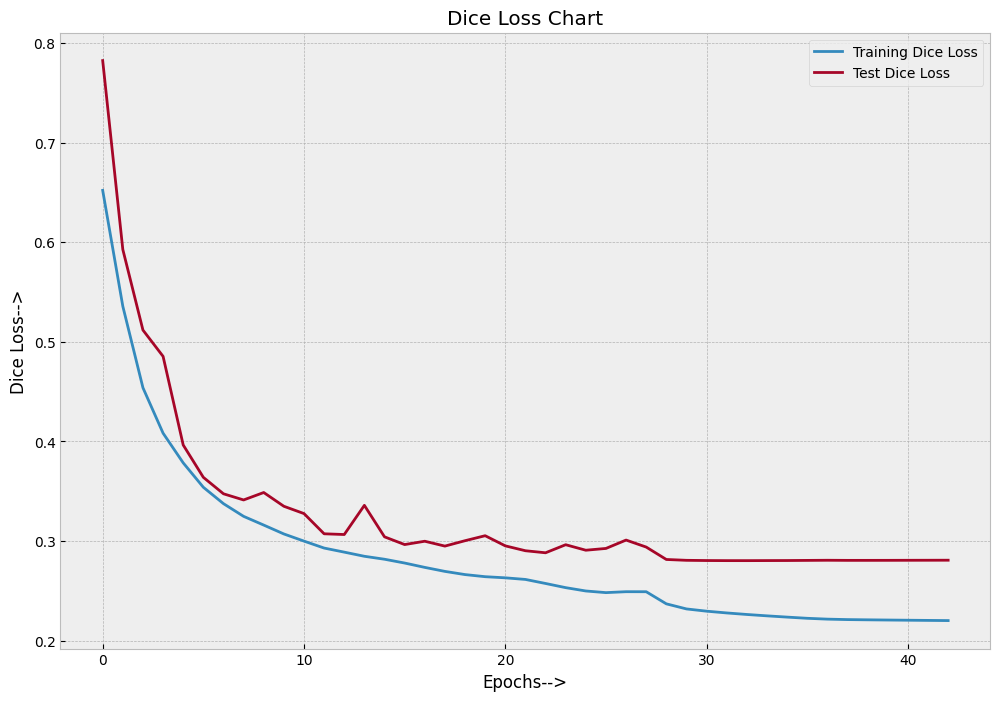

In [23]:
plot_values(df,'epoch','loss','val_loss','Epochs','Dice Loss',ch=0)

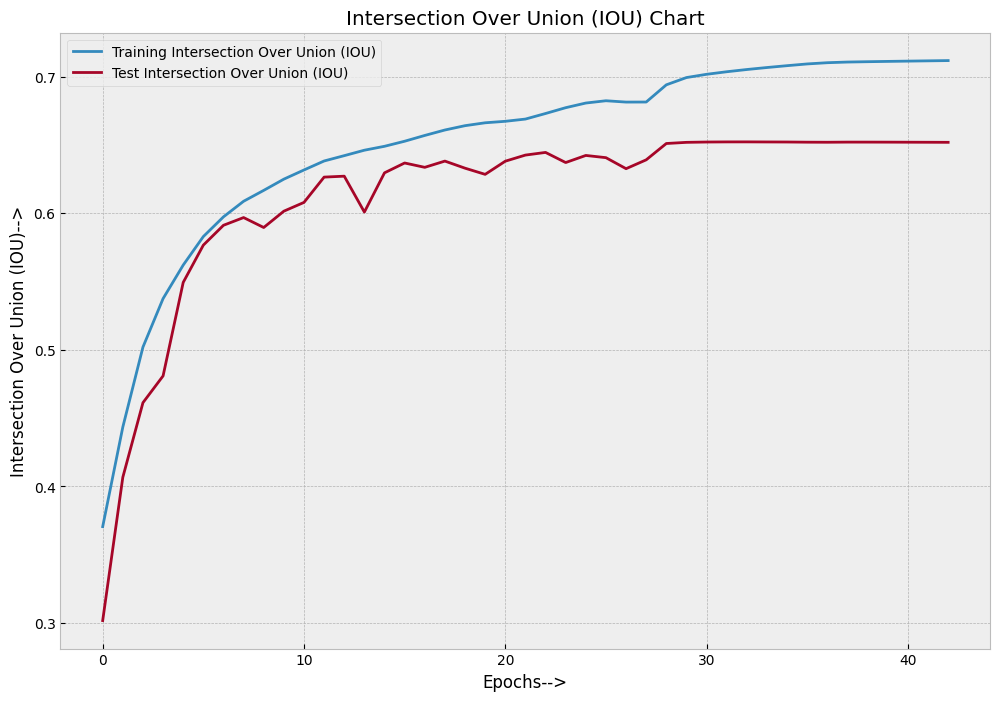

In [24]:
plot_values(df,'epoch','iou','val_iou','Epochs','Intersection Over Union (IOU)',ch=0)

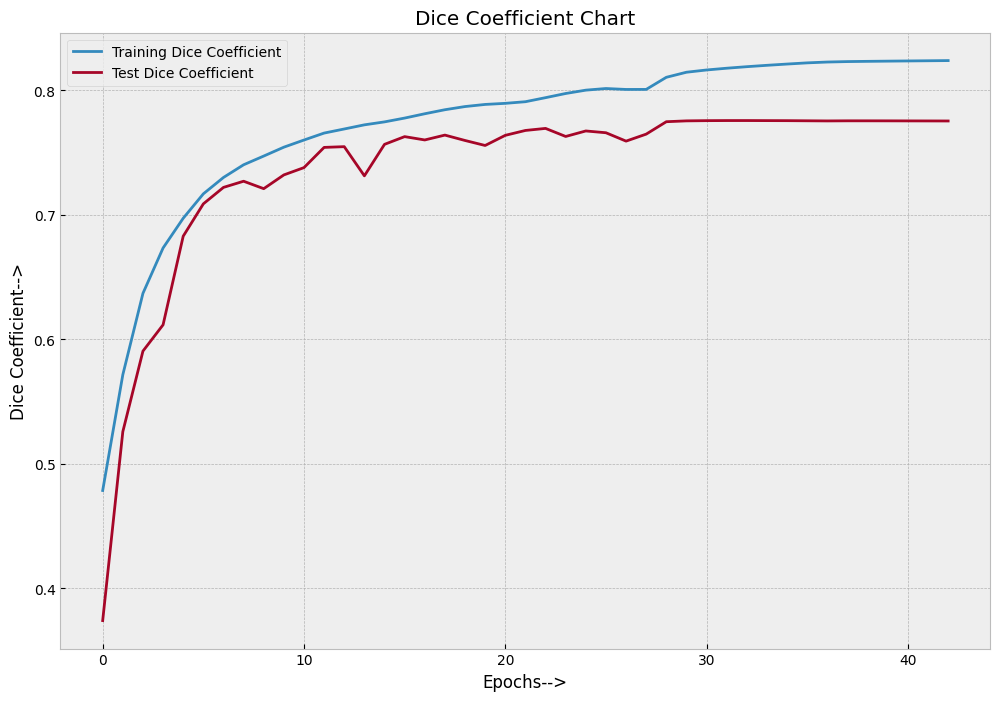

In [25]:
plot_values(df,'epoch','dice_coef','val_dice_coef','Epochs','Dice Coefficient',ch=0)

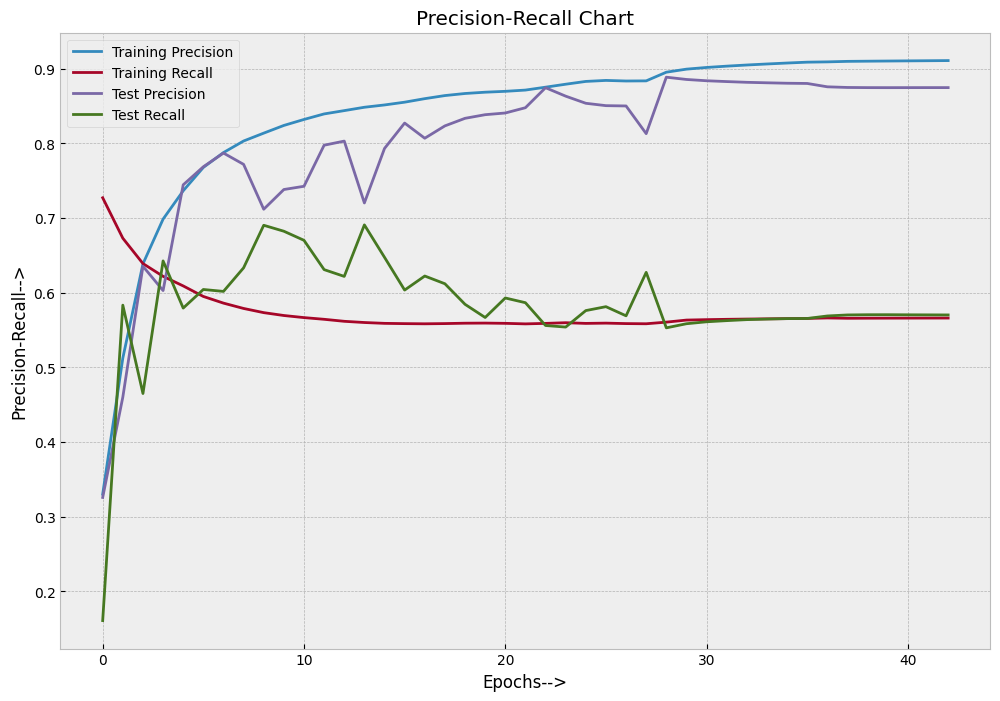

In [26]:
plot_values(df,'epoch',['precision','recall'],['val_precision','val_recall'],'Epochs',['Precision','Recall'],ch=4)

In [29]:
zp = shutil.make_archive('Retina_seg', 'zip', os.path.join(os.getcwd(),'Retina_Seg'))

In [30]:
shutil.rmtree(os.path.join(os.getcwd(),'Retina_Seg'))